In [69]:
# System packages
import os
import re
import sys
import warnings
# Data related
import numpy as np 
import pandas as pd 

# sklearn  
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score,  StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD,OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
from tensorflow.keras import backend

In [65]:
# Add utils_functions.py as a dataset
from shutil import copyfile

# Copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/utils-functions/utils_functions.py", dst = '/kaggle/working/utils_functions.py')
from utils_functions import *

## 0 Preprocessing

In [ ]:
# Train data for training and validation
df_train = pd.read_csv('train_variants_text.csv') 
train = df_process(df_train)
train['data_type']='train'
print('train data size:',len(train))

In [ ]:
# Test data for submission
df_test = pd.read_csv('stage2_test_variants_text.csv') 
test = df_process(df_test)
test['data_type']='test'
print('test data size:',len(test))

### Combine both train and test data => all_data

In [ ]:
all_data = pd.concat([train, test], sort=False)
all_data['Text']=all_data['Text'].apply(textClean_full)
print('all_data size:',len(all_data))
all_data.to_csv('pm_all_data_clean_class_20190614.csv', index= False)   

## 1 Load preprocessed all_data 

In [14]:
all_data= pd.read_csv('/Users/j/Dropbox/Learn/health_precisionmedicine/data/processed/pm_all_data_clean_class_20190614.csv')
all_data.head(1)

,ID,Gene,Variation,Text,data_type,Class
0,0,FAM58A,Truncating Mutations,cyclin dependent kinases cdks regulate variety...,train,1.0


### Group Variantions 

In [408]:
df = group_Variation(df)

In [411]:
groupby_col_size(df,'Variation')

Variation
snv_other               3812
fusions                  197
truncating mutations     112
del                       95
amplification             77
overexpression             6
promoter                   3
dtype: int64

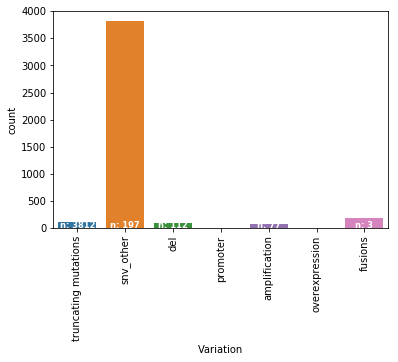

In [412]:
fig =col_count_plot(df, 'Variation')

## 2. Label Encoding train.Class

In [ ]:
train_y  = label_encoder(train_size)


## 3 Build Doc2Vec model

In [414]:
sentences = constructLabeledSentences(all_data,'Text')
#sentences[0]

In [416]:
text_input_dim =300
train_size = 3316
test_size=986

In [417]:
text_model = get_doc2vec_model(sentences, '../input/pm-model-doc2vec-all/doc2vec_all_20190614.d2v',text_input_dim=text_input_dim)

Found ../input/pm-model-doc2vec-all/doc2vec_all_20190614.d2v


## 4. Featurize Text 

In [419]:
text_train_arrays, text_test_arrays = build_text_array(text_model, \
                                                       text_input_dim,\
                                                       train_size,\
                                                       test_size)

In [420]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)

(3316, 300)
(986, 300)


In [421]:
print(text_train_arrays[0][:10])

[ 0.49902058 -0.21902579  0.23566465  0.6866526  -0.76406091 -0.47411516
 -0.10866016  0.80849326  0.36930278  0.03643488]


## 5 Feature Gene and Variation 

In [649]:
# Dimension reduction
from sklearn.decomposition import TruncatedSVD
gene_dim=200
variation_dim=6

# Pipeline for Gene
Gene = Pipeline([
    ('selector',ItemSelector(key="Gene")),
     ('onehot',OneHotEncoder()),
    ('tsvd',TruncatedSVD(n_components=gene_dim, n_iter=gene_dim, random_state=12))
])

# Pipeline for Variation
Variation = Pipeline([
    ('selector',ItemSelector(key="Variation")),
    ('onehot',OneHotEncoder()),
    ('tsvd',TruncatedSVD(n_components=variation_dim, n_iter=variation_dim, random_state=12))
])

In [650]:
Gene_vector = Gene.fit_transform(all_data)
print(Gene_vector.shape)


(4302, 200)


In [651]:
Variation_vector = Variation.fit_transform(all_data)
print(Variation_vector.shape)


(4302, 6)


## 5.1 Stack 3 features 

In [652]:
train_set, test_set = stack_3_features(Gene_vector, \
                         Variation_vector,\
                         train_size,\
                         text_train_arrays, \
                         text_test_arrays)

In [653]:
print(train_set.shape)
print(test_set.shape)
#print(train_set[0][:10])
input_shape=train_set.shape[1]
print(input_shape)

(3316, 506)
(986, 506)
506


### Training

In [654]:
# Import KerasRegressor model
from keras.wrappers.scikit_learn import KerasRegressor
clf = KerasRegressor(build_fn=baseline_model)

In [655]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
# Build estimator
def build_estimator(clf,train_set, train_y, epochs,verbose):
    # split data 
    X_train, X_validation, y_train, y_validation = train_test_split(train_set, train_y, test_size=0.33, stratify=train_y, shuffle= True, random_state=42)
    # Save best model 
    weightsname = '{}{:%Y%m%dT%H%M%S}.hd5'.format(('doc2vec_keras'), datetime.datetime.now())
    checkpointer = ModelCheckpoint(filepath=weightsname, verbose=verbose, save_best_only=True)
    # Build estimator   
    estimator=clf.fit(X_train, y_train, batch_size=32, epochs=epochs, callbacks=[checkpointer],validation_data=(X_validation, y_validation))
    #estimator=clf.fit(train_set, train_y, validation_split=0.33, epochs=epochs, batch_size=32)
    return estimator

In [656]:
estimator1=build_estimator(clf,train_set, train_y, epochs=50,verbose=1)

Train on 2221 samples, validate on 1095 samples
Epoch 1/50
2221/2221 [==============================] - 1s 465us/step - loss: 2.0364 - acc: 0.2805 - val_loss: 1.8959 - val_acc: 0.2868

Epoch 00001: val_loss improved from inf to 1.89586, saving model to doc2vec_keras20190616T155756.hd5
Epoch 2/50
2221/2221 [==============================] - 0s 76us/step - loss: 1.8470 - acc: 0.2949 - val_loss: 1.7883 - val_acc: 0.3525

Epoch 00002: val_loss improved from 1.89586 to 1.78833, saving model to doc2vec_keras20190616T155756.hd5
Epoch 3/50
2221/2221 [==============================] - 0s 78us/step - loss: 1.7119 - acc: 0.3647 - val_loss: 1.5965 - val_acc: 0.3900

Epoch 00003: val_loss improved from 1.78833 to 1.59648, saving model to doc2vec_keras20190616T155756.hd5
Epoch 4/50
2221/2221 [==============================] - 0s 77us/step - loss: 1.5900 - acc: 0.4070 - val_loss: 1.5382 - val_acc: 0.4374

Epoch 00004: val_loss improved from 1.59648 to 1.53819, saving model to doc2vec_keras20190616T15

2221/2221 [==============================] - 0s 82us/step - loss: 0.9069 - acc: 0.6632 - val_loss: 1.1560 - val_acc: 0.6110

Epoch 00038: val_loss did not improve from 1.15341
Epoch 39/50
2221/2221 [==============================] - 0s 83us/step - loss: 0.9107 - acc: 0.6610 - val_loss: 1.1998 - val_acc: 0.5945

Epoch 00039: val_loss did not improve from 1.15341
Epoch 40/50
2221/2221 [==============================] - 0s 75us/step - loss: 0.8882 - acc: 0.6731 - val_loss: 1.1807 - val_acc: 0.6037

Epoch 00040: val_loss did not improve from 1.15341
Epoch 41/50
2221/2221 [==============================] - 0s 79us/step - loss: 0.8549 - acc: 0.6776 - val_loss: 1.1893 - val_acc: 0.6009

Epoch 00041: val_loss did not improve from 1.15341
Epoch 42/50
2221/2221 [==============================] - 0s 80us/step - loss: 0.8471 - acc: 0.6682 - val_loss: 1.1681 - val_acc: 0.6174

Epoch 00042: val_loss did not improve from 1.15341
Epoch 43/50
2221/2221 [==============================] - 0s 79us/step - 

### Inspect training results

In [657]:
train_history= save_history_df(estimator1)
print('The best epoch is ')
print(train_history.loc[train_history['val_acc'] == train_history.val_acc.max()])


The best epoch is 
       val_loss   val_acc      loss      acc
epoch                                       
49      1.20318  0.623744  0.798197  0.69113


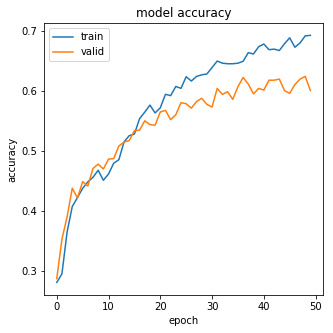

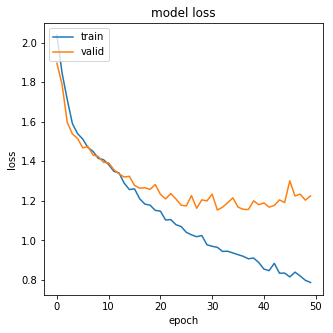

In [658]:
plot_history(estimator1)

### 5.2 Stack 2 features (Variation + Text)

In [659]:
train_set, test_set = stack_2_features(Variation_vector,\
                         train_size,\
                         text_train_arrays, \
                         text_test_arrays)

In [660]:
print(train_set.shape)
print(test_set.shape)
#print(train_set[0][:10])
input_shape=train_set.shape[1]
print(input_shape)

(3316, 306)
(986, 306)
306


In [661]:
estimator2=build_estimator(clf,train_set, train_y, epochs=50,verbose=1)

Train on 2221 samples, validate on 1095 samples
Epoch 1/50
2221/2221 [==============================] - 1s 615us/step - loss: 2.0298 - acc: 0.2738 - val_loss: 1.8828 - val_acc: 0.2868

Epoch 00001: val_loss improved from inf to 1.88279, saving model to doc2vec_keras20190616T155842.hd5
Epoch 2/50
2221/2221 [==============================] - 0s 105us/step - loss: 1.8342 - acc: 0.3012 - val_loss: 1.7686 - val_acc: 0.3626

Epoch 00002: val_loss improved from 1.88279 to 1.76860, saving model to doc2vec_keras20190616T155842.hd5
Epoch 3/50
2221/2221 [==============================] - 0s 100us/step - loss: 1.6983 - acc: 0.3751 - val_loss: 1.6097 - val_acc: 0.3945

Epoch 00003: val_loss improved from 1.76860 to 1.60967, saving model to doc2vec_keras20190616T155842.hd5
Epoch 4/50
2221/2221 [==============================] - 0s 88us/step - loss: 1.5973 - acc: 0.4115 - val_loss: 1.5496 - val_acc: 0.4155

Epoch 00004: val_loss improved from 1.60967 to 1.54958, saving model to doc2vec_keras20190616T


Epoch 00038: val_loss did not improve from 1.24788
Epoch 39/50
2221/2221 [==============================] - 0s 77us/step - loss: 1.0016 - acc: 0.6308 - val_loss: 1.2888 - val_acc: 0.5735

Epoch 00039: val_loss did not improve from 1.24788
Epoch 40/50
2221/2221 [==============================] - 0s 75us/step - loss: 0.9749 - acc: 0.6385 - val_loss: 1.2706 - val_acc: 0.5826

Epoch 00040: val_loss did not improve from 1.24788
Epoch 41/50
2221/2221 [==============================] - 0s 82us/step - loss: 1.0105 - acc: 0.6204 - val_loss: 1.2794 - val_acc: 0.5872

Epoch 00041: val_loss did not improve from 1.24788
Epoch 42/50
2221/2221 [==============================] - 0s 76us/step - loss: 0.9851 - acc: 0.6281 - val_loss: 1.2922 - val_acc: 0.5808

Epoch 00042: val_loss did not improve from 1.24788
Epoch 43/50
2221/2221 [==============================] - 0s 76us/step - loss: 0.9723 - acc: 0.6403 - val_loss: 1.2863 - val_acc: 0.5826

Epoch 00043: val_loss did not improve from 1.24788
Epoch 44

In [662]:
train_history= save_history_df(estimator2)
print('The best epoch is ')
print(train_history.loc[train_history['val_acc'] == train_history.val_acc.max()])


The best epoch is 
       val_loss   val_acc      loss       acc
epoch                                        
47     1.297229  0.607306  0.945354  0.649257


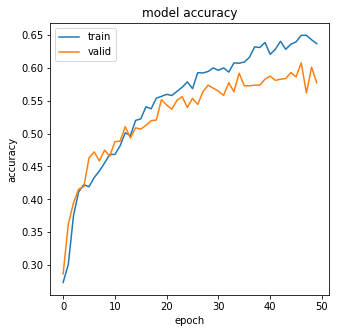

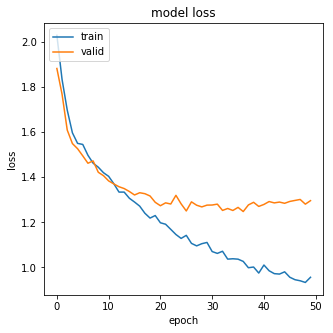

In [663]:
plot_history(estimator2)

### 5.3 Text feature

In [664]:
train_set, test_set = (text_train_arrays, \
                         text_test_arrays)

In [665]:
print(train_set.shape)
print(test_set.shape)
#print(train_set[0][:10])
input_shape=train_set.shape[1]
print(input_shape)

(3316, 300)
(986, 300)
300


In [666]:
estimator3=build_estimator(clf,train_set, train_y, epochs=50,verbose=1)

Train on 2221 samples, validate on 1095 samples
Epoch 1/50
2221/2221 [==============================] - 1s 580us/step - loss: 2.0304 - acc: 0.2724 - val_loss: 1.8835 - val_acc: 0.2868

Epoch 00001: val_loss improved from inf to 1.88349, saving model to doc2vec_keras20190616T155900.hd5
Epoch 2/50
2221/2221 [==============================] - 0s 76us/step - loss: 1.8374 - acc: 0.2936 - val_loss: 1.7699 - val_acc: 0.3680

Epoch 00002: val_loss improved from 1.88349 to 1.76991, saving model to doc2vec_keras20190616T155900.hd5
Epoch 3/50
2221/2221 [==============================] - 0s 74us/step - loss: 1.7098 - acc: 0.3647 - val_loss: 1.5950 - val_acc: 0.4110

Epoch 00003: val_loss improved from 1.76991 to 1.59503, saving model to doc2vec_keras20190616T155900.hd5
Epoch 4/50
2221/2221 [==============================] - 0s 76us/step - loss: 1.6034 - acc: 0.4007 - val_loss: 1.5324 - val_acc: 0.4420

Epoch 00004: val_loss improved from 1.59503 to 1.53241, saving model to doc2vec_keras20190616T15


Epoch 00038: val_loss did not improve from 1.25323
Epoch 39/50
2221/2221 [==============================] - 0s 79us/step - loss: 1.0306 - acc: 0.6092 - val_loss: 1.2900 - val_acc: 0.5662

Epoch 00039: val_loss did not improve from 1.25323
Epoch 40/50
2221/2221 [==============================] - 0s 76us/step - loss: 1.0166 - acc: 0.6227 - val_loss: 1.3184 - val_acc: 0.5653

Epoch 00040: val_loss did not improve from 1.25323
Epoch 41/50
2221/2221 [==============================] - 0s 77us/step - loss: 1.0124 - acc: 0.6123 - val_loss: 1.3017 - val_acc: 0.5808

Epoch 00041: val_loss did not improve from 1.25323
Epoch 42/50
2221/2221 [==============================] - 0s 83us/step - loss: 1.0017 - acc: 0.6263 - val_loss: 1.3132 - val_acc: 0.5699

Epoch 00042: val_loss did not improve from 1.25323
Epoch 43/50
2221/2221 [==============================] - 0s 75us/step - loss: 0.9948 - acc: 0.6204 - val_loss: 1.3212 - val_acc: 0.5607

Epoch 00043: val_loss did not improve from 1.25323
Epoch 44

In [667]:
train_history= save_history_df(estimator3)
print('The best epoch is ')
print(train_history.loc[train_history['val_acc'] == train_history.val_acc.max()])


The best epoch is 
       val_loss   val_acc      loss       acc
epoch                                        
41     1.301694  0.580822  1.012364  0.612337


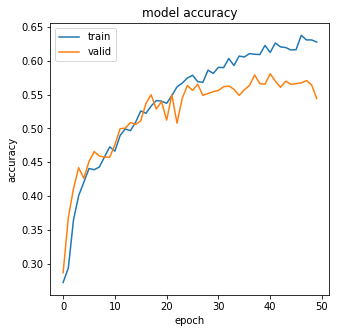

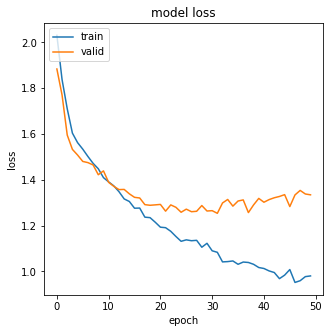

In [668]:
plot_history(estimator3)

## 6 How well can the features be explained? 

In [617]:
# What is the best n_components for Gene TSVD
Genes = onehot_ft(df,'Gene')
gene_dim=200
# TSVD
svd = TruncatedSVD(n_components=gene_dim, n_iter=gene_dim, random_state=12)
svd.fit(Genes) 

# Select the n_components which can explain 95% variance 
tsvd_var_ratios = svd.explained_variance_ratio_
select_n_components(tsvd_var_ratios, 0.95)

# Explain
var_explained = svd.explained_variance_ratio_.sum()
var_explained 


0.9277056843357011

In [611]:
# Dimension reduction
from sklearn.decomposition import TruncatedSVD
gene_dim=200
variation_dim=6

# Pipeline for Gene
Gene = Pipeline([
    ('selector',ItemSelector(key="Gene")),
    ('converter',Converter()),
     ('onehot',OneHotEncoder()),
    ('tsvd',TruncatedSVD(n_components=gene_dim, n_iter=gene_dim, random_state=12))
])


# Pipeline for Variation
Variation = Pipeline([
    ('selector',ItemSelector(key="Variation")),
    ('converter',Converter()),
    ('onehot',OneHotEncoder()),   
    ('tsvd',TruncatedSVD(n_components=variation_dim, n_iter=variation_dim, random_state=12))
])

In [591]:
# OneHotEncoder
def onehot_ft(df,colname):
    enc = OneHotEncoder(handle_unknown='ignore')
    temp = df[colname].values.reshape(-1,1)
    onehot_col = enc.fit_transform(temp)
    return onehot_col

In [616]:
# How much variance can be explained for Variation using TSVD n_components=6
Variations = onehot_ft(df,'Variation')

variation_dim=6
svd = TruncatedSVD(n_components=variation_dim, n_iter=variation_dim, random_state=12)
svd.fit(Variations) 
var_explained = svd.explained_variance_ratio_.sum()
var_explained # 0.990107962434239

0.9967011194248345

In [618]:
# What is the best n_components for Gene TSVD
Genes = onehot_ft(df,'Gene')
# Select the best n_components number
tsvd_var_ratios = svd.explained_variance_ratio_
select_n_components(tsvd_var_ratios, 0.95)

200

In [669]:
gene_dim=200
svd = TruncatedSVD(n_components=gene_dim, n_iter=500, random_state=12)
svd.fit(Genes) 

var_explained = svd.explained_variance_ratio_.sum()
var_explained 

0.9277073375650529